<a href="https://colab.research.google.com/github/Emsh1379/Stock_prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!pip install yfinance -q
!pip install keras-tuner -q

In [106]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [107]:
import yfinance as yf

# Visualize Data

In [108]:
ms = yf.download("GOOG",
            start = "2012-01-01",
            end ="2021-12-31",
            progress = False )
df = ms[["Adj Close","Open","Close","High","Low"]].round(3)
df['Date']= df.index
df.head()

,Adj Close,Open,Close,High,Low,Date
Date,,,,,,
2012-01-03,16.573,16.263,16.573,16.641,16.248,2012-01-03
2012-01-04,16.645,16.564,16.645,16.694,16.454,2012-01-04
2012-01-05,16.414,16.491,16.414,16.537,16.344,2012-01-05
2012-01-06,16.190,16.417,16.190,16.438,16.184,2012-01-06
2012-01-09,15.503,16.102,15.503,16.115,15.473,2012-01-09


<Axes: xlabel='Date'>

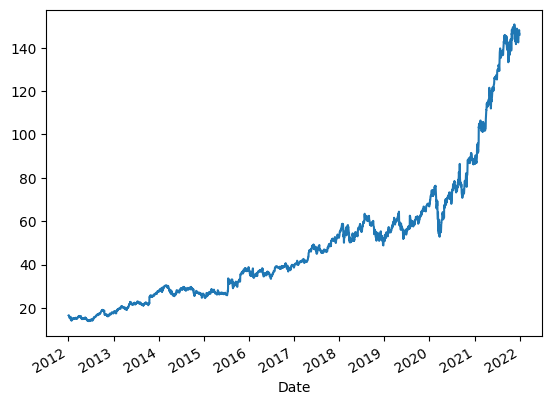

In [109]:
df.Close.plot()

#SVM

R2 score: 0.93471250801891
Mean absolute error: 4.0326415294603


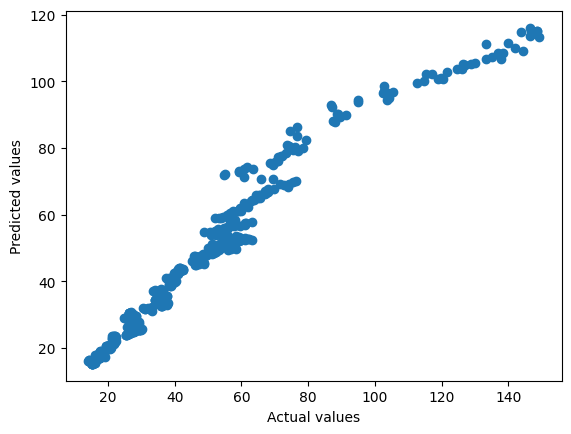

In [110]:
# build model of svm for date and close values

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(
    df[['Date']], df['Close'], test_size=0.2, random_state=42)
# fit SVR model on training data
model = SVR()
model.fit(x_train, y_train)
# make predictions on test data
y_pred = model.predict(x_test)
# evaluate model performance
print('R2 score:', model.score(x_test, y_test))
print('Mean absolute error:', np.mean(np.abs(y_test - y_pred)))
# plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


<Axes: xlabel='Date'>

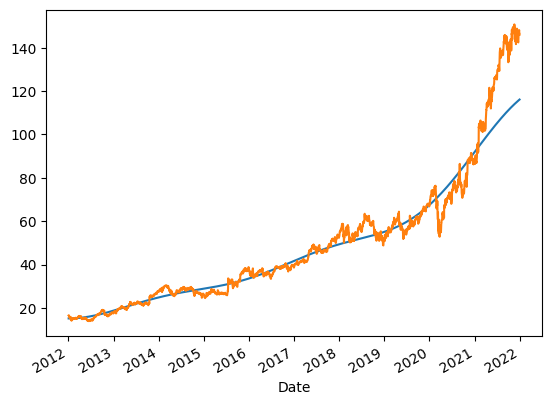

In [111]:
df['Prediction'] = model.predict(df[['Date']])
df.Prediction.plot()
df.Close.plot()


# Train Data and Test Data split

In [112]:
# Determin ratio of train to test ratio
ratio = 0.8
split_point = int(df.Close.values.reshape(-1,1).shape[0] * ratio)
train_df = df[:split_point].Close.values.reshape(-1,1)
test_df = df[split_point:].Close.values.reshape(-1,1)


In [113]:
X_train = []
y_train = []
y_steps = 5
X_steps = 10
for i in range(X_steps, len(train_df) - y_steps + 1):
  X_train.append(train_df[i-X_steps:i,0])
  y_train.append(train_df[i:i+y_steps,0])

X = df.Close.values
X = X[len(X)-len(test_df)-X_steps:]
X = X.reshape(-1,1)

X_test = []
y_test = []
for i in range(X_steps, len(test_df) - y_steps + X_steps + 1):
  X_test.append(X[i-X_steps:i,0])
  y_test.append(X[i:i+y_steps,0])






In [114]:
test_df[-15:,0]

array([148.106, 148.675, 146.704, 144.971, 147.368, 144.839, 142.803,
       142.402, 144.221, 146.949, 147.143, 148.064, 146.448, 146.505,
       146.003])

In [115]:
X_test[-1]


array([148.106, 148.675, 146.704, 144.971, 147.368, 144.839, 142.803,
       142.402, 144.221, 146.949])

In [116]:
y_test[-1]


array([147.143, 148.064, 146.448, 146.505, 146.003])

In [117]:
np.array(X_train).shape


(1998, 10)

In [118]:
def ts_data(df,X_steps,y_steps):
  split_point = int(df.Close.values.reshape(-1,1).shape[0] * ratio)
  train_df = df[:split_point].Close.values.reshape(-1,1)
  test_df = df[split_point:].Close.values.reshape(-1,1)

  sc = MinMaxScaler(feature_range=(0,1))
  train_df = sc.fit_transform(train_df)


  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df) - y_steps + 1):
    X_train.append(train_df[i-X_steps:i,0])
    y_train.append(train_df[i:i+y_steps,0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1,1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df) - y_steps + X_steps + 1):
    X_test.append(X[i-X_steps:i,0])
    y_test.append(X[i:i+y_steps,0])
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

  return X_train,y_train,X_test,y_test,sc






# Determine X_steps and y_steps

In [119]:
X_steps,y_steps = 6,2

In [120]:
X_train,y_train,X_test,y_test,sc = ts_data(df,X_steps,y_steps)



In [121]:
X_train.shape



(2005, 6, 1)

In [122]:
y_train.shape




(2005, 2)

In [123]:
X_test.shape

(503, 6, 1)

In [124]:
y_test.shape



(503, 2)

# Simple RNN-Model

In [125]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [126]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int("num_layers", 1, 5)):
    model.add(SimpleRNN(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(SimpleRNN(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    directory='my_dir',
    max_trials=15,
    project_name='simpleRNN_tuning'
    )

Reloading Tuner from my_dir/simpleRNN_tuning/tuner0.json


In [127]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]

In [128]:
simple_rnn_model = best_model

In [129]:
simple_rnn_pred = simple_rnn_model.predict(X_test)
simple_rnn_pred.shape


16/16 [==============================] - 1s 6ms/step


(503, 2)

In [130]:
def prediction_plot(predictions):
  fig , ax = plt.subplots(figsize=(10,5))
  ax.plot(df[split_point:].index[:len(y_test)],
          sc.inverse_transform(y_test[:,0].reshape(-1,1)),label = "Real")
  ax.plot(df[split_point:].index[:len(y_test)],
          sc.inverse_transform(predictions[:,0].reshape(-1,1)),label = "Prediction")

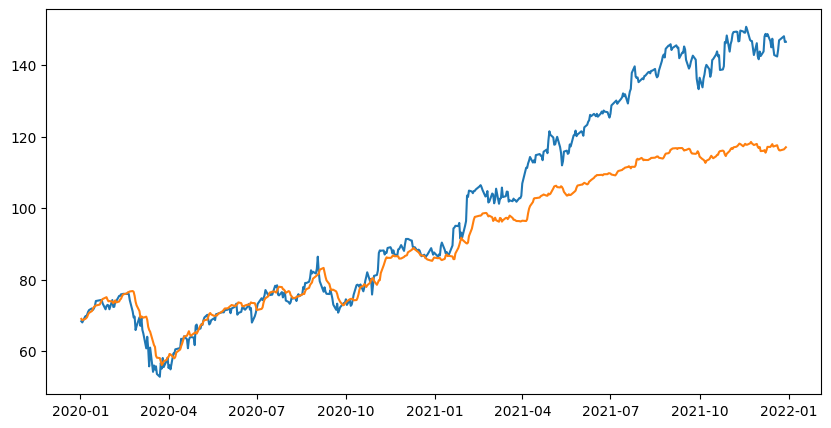

In [131]:
prediction_plot(simple_rnn_pred)



In [132]:
simple_rnn_model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 8ms/step - loss: 0.2256


0.22556817531585693

In [133]:
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6, 224)            50624     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 224)               100576    
                                                                 
 dense (Dense)               (None, 2)                 450       
                                                                 
Total params: 151650 (592.38 KB)
Trainable params: 151650 (592.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# LSTM

In [134]:
from keras.layers import LSTM

In [135]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(LSTM(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(LSTM(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='LSTM_tuning'
    )

Reloading Tuner from my_dir/LSTM_tuning/tuner0.json


In [136]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
lstm = best_model

16/16 [==============================] - 17s 108ms/step


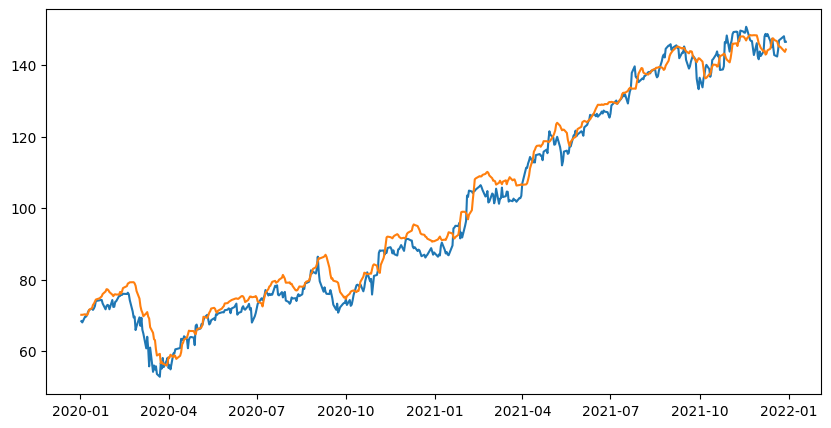

In [137]:
prediction_plot(lstm.predict(X_test))


In [138]:
lstm.evaluate(X_test,y_test)

16/16 [==============================] - 7s 160ms/step - loss: 0.0663


0.06633444130420685

In [139]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 480)            925440    
                                                                 
 lstm_1 (LSTM)               (None, 6, 288)            885888    
                                                                 
 lstm_2 (LSTM)               (None, 6, 288)            664704    
                                                                 
 lstm_3 (LSTM)               (None, 288)               664704    
                                                                 
 dense (Dense)               (None, 2)                 578       
                                                                 
Total params: 3141314 (11.98 MB)
Trainable params: 3141314 (11.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Combimition of LSTM and GRU

In [140]:
from keras.layers import GRU
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(LSTM(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


In [141]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='Combined_tuning'
    )

Reloading Tuner from my_dir/Combined_tuning/tuner0.json


In [142]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
Combined = best_model


16/16 [==============================] - 11s 125ms/step


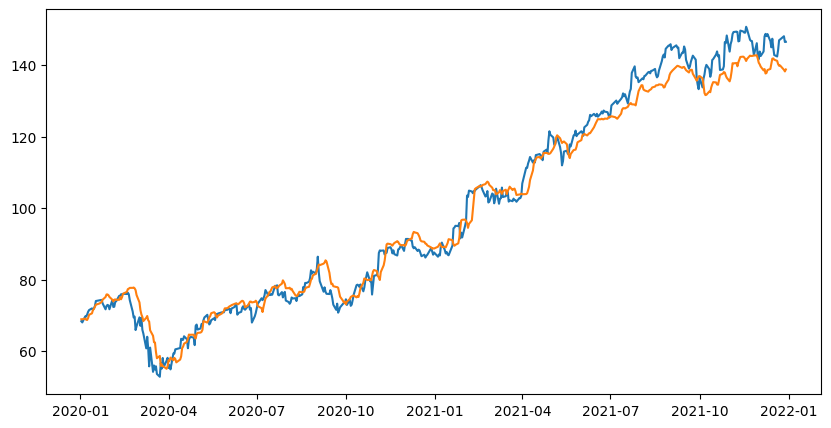

In [143]:
prediction_plot(Combined.predict(X_test))

In [144]:
Combined.evaluate(X_test,y_test)

16/16 [==============================] - 4s 77ms/step - loss: 0.0629


0.06294739246368408

In [145]:
Combined.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 160)            78240     
                                                                 
 lstm (LSTM)                 (None, 6, 160)            205440    
                                                                 
 gru_1 (GRU)                 (None, 6, 448)            819840    
                                                                 
 lstm_1 (LSTM)               (None, 6, 448)            1607424   
                                                                 
 gru_2 (GRU)                 (None, 6, 288)            637632    
                                                                 
 lstm_2 (LSTM)               (None, 6, 288)            664704    
                                                                 
 gru_3 (GRU)                 (None, 288)               4

# GRU

In [146]:
from keras.layers import GRU
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32), return_sequences=True))
  model.add(GRU(hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)))
  model.add(keras.layers.Dense(2, activation=hp.Choice("activation", ["relu", "Softmax"])))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error',
                )
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='GRU_tuning'
    )

Reloading Tuner from my_dir/GRU_tuning/tuner0.json


In [147]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
GRU = best_model

16/16 [==============================] - 3s 38ms/step


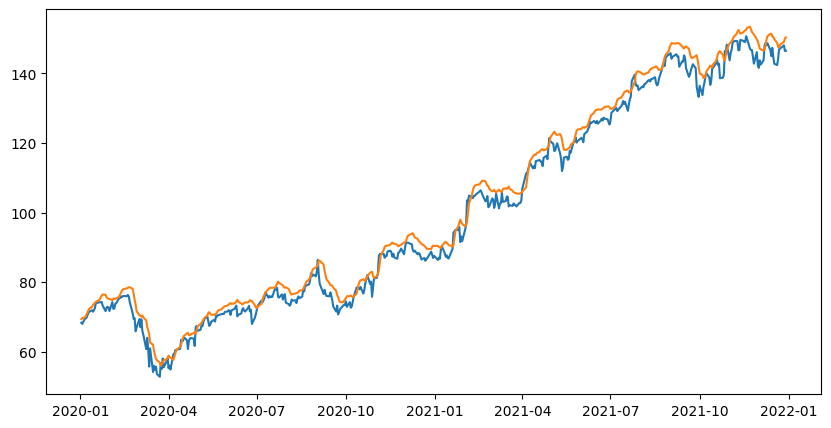

In [148]:
prediction_plot(GRU.predict(X_test))

In [149]:
GRU.evaluate(X_test,y_test)

16/16 [==============================] - 2s 38ms/step - loss: 0.0442


0.04418989270925522

In [150]:
GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 480)            695520    
                                                                 
 gru_1 (GRU)                 (None, 480)               1385280   
                                                                 
 dense (Dense)               (None, 2)                 962       
                                                                 
Total params: 2081762 (7.94 MB)
Trainable params: 2081762 (7.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compare mean absolute error of models

16/16 [==============================] - 5s 130ms/step - loss: 0.0629


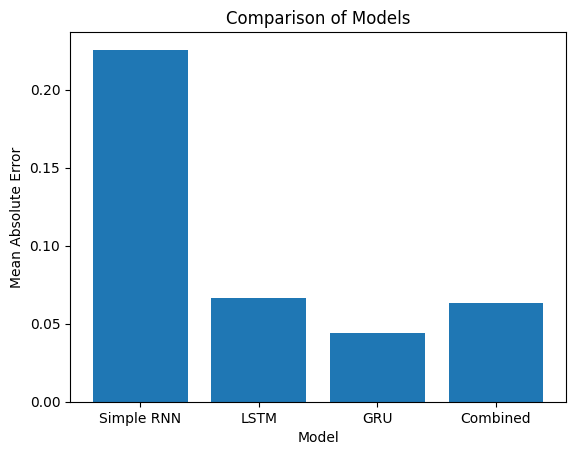

In [151]:
#Compare mean absolute error of models

models = [simple_rnn_model, lstm, GRU, Combined]
model_names = ["Simple RNN", "LSTM", "GRU", "Combined"]
mae = []
for model, name in zip(models, model_names):
  mae.append(model.evaluate(X_test, y_test))

plt.bar(model_names, mae)
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.title("Comparison of Models")
plt.show()


# Tain plot

63/63 [==============================] - 7s 103ms/step


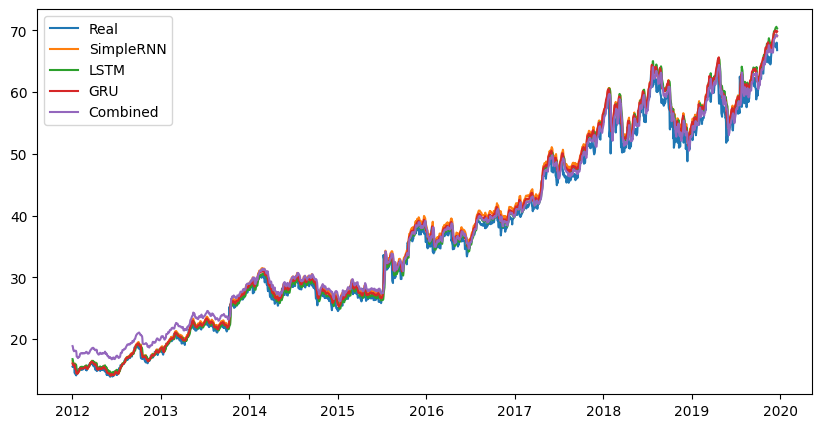

In [152]:
fig , ax = plt.subplots(figsize=(10,5))
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(y_train[:,0].reshape(-1,1)),label = "Real")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(simple_rnn_model.predict(X_train)[:,0].reshape(-1,1)),label = "SimpleRNN")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(lstm.predict(X_train)[:,0].reshape(-1,1)),label = "LSTM")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(GRU.predict(X_train)[:,0].reshape(-1,1)),label = "GRU")
ax.plot(df[:split_point].index[:len(y_train)],
        sc.inverse_transform(Combined.predict(X_train)[:,0].reshape(-1,1)),label = "Combined")
plt.legend()

# Test plot

16/16 [==============================] - 1s 80ms/step


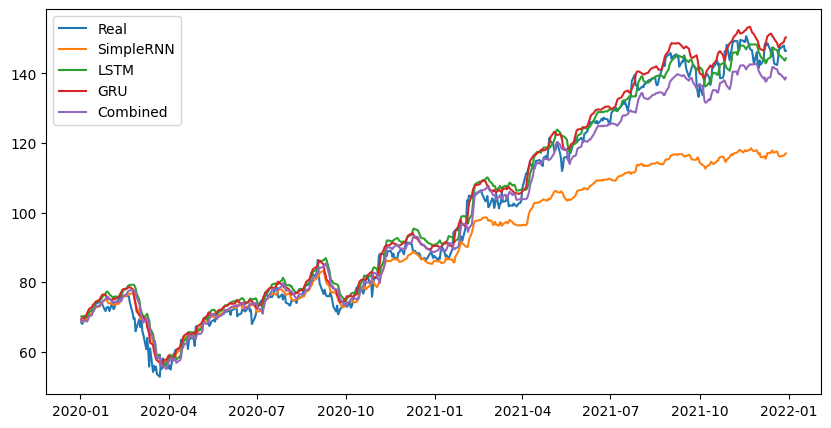

In [153]:
fig , ax = plt.subplots(figsize=(10,5))
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(y_test[:,0].reshape(-1,1)),label = "Real")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(simple_rnn_model.predict(X_test)[:,0].reshape(-1,1)),label = "SimpleRNN")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(lstm.predict(X_test)[:,0].reshape(-1,1)),label = "LSTM")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(GRU.predict(X_test)[:,0].reshape(-1,1)),label = "GRU")
ax.plot(df[split_point:].index[:len(y_test)],
        sc.inverse_transform(Combined.predict(X_test)[:,0].reshape(-1,1)),label = "Combined")
plt.legend()
